In [1]:
%run flow_tools.py

In [2]:
folder= box_dir + "VEGAS-MTK/Flow/20210315 - BHK21 with Spike and Cells/"

In [3]:
df = load_data(folder, colnames=["WellName", "Receiver","Sender", "Dose", 'Replicate'])
df2 = clean_data(df)

In [4]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

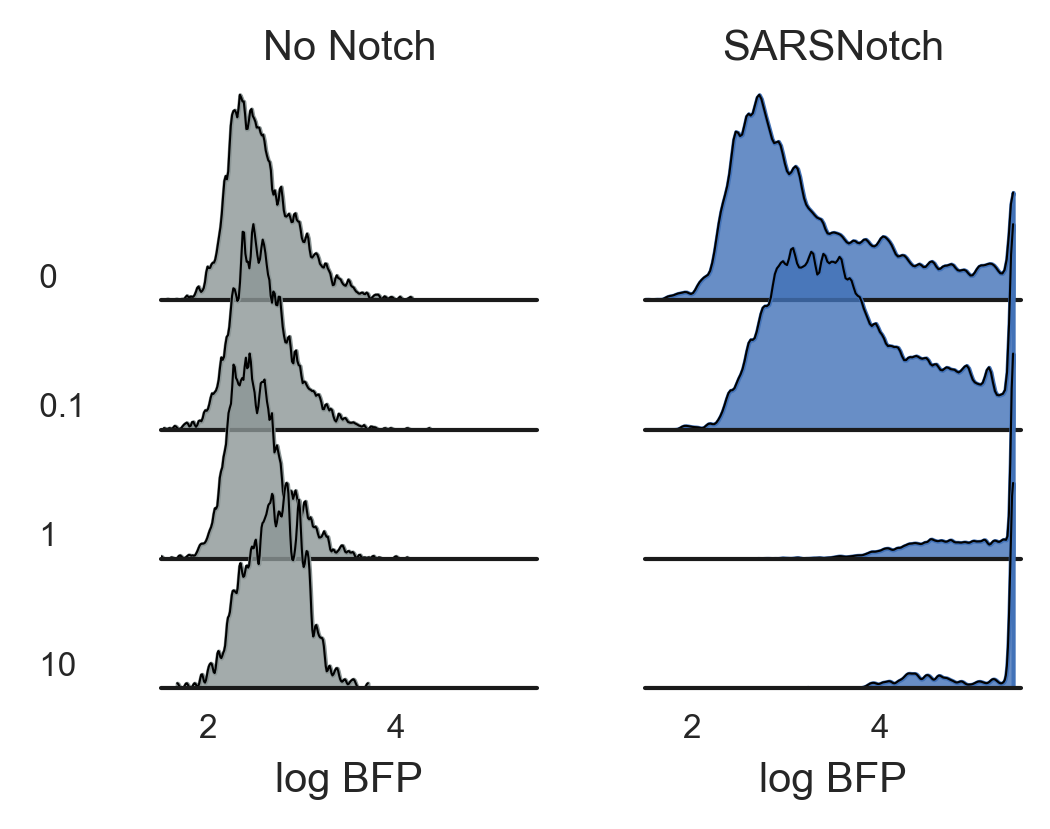

In [5]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    doses = [str(x) for x in [0,0.1,1,10]]
    notches = ['No Notch', 'SARSNotch']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Sender'] == 'None') &
                               (df2['logFITC-A'] > 5)],
                      row='Dose', col='Receiver', hue='Receiver',sharey=False, aspect=2.5, height=0.65, 
                      row_order = doses,
                      hue_order = notches,
                      col_order = notches,
                      xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    left_axes = [g.facet_axis(r, 0) for r in range(len(doses))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_dpi(300)
    g.set_xlabels("log BFP")
    plt.savefig(outputdir+'bhk_no-notch_spike_histogram.svg')

In [6]:
filters = ((df2['logFITC-A'] > 4) &
           (df2['Sender'] == 'None'))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Receiver', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])

/Volumes/Coatamer/Users/weinberz/miniconda3/envs/flow/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  import sys


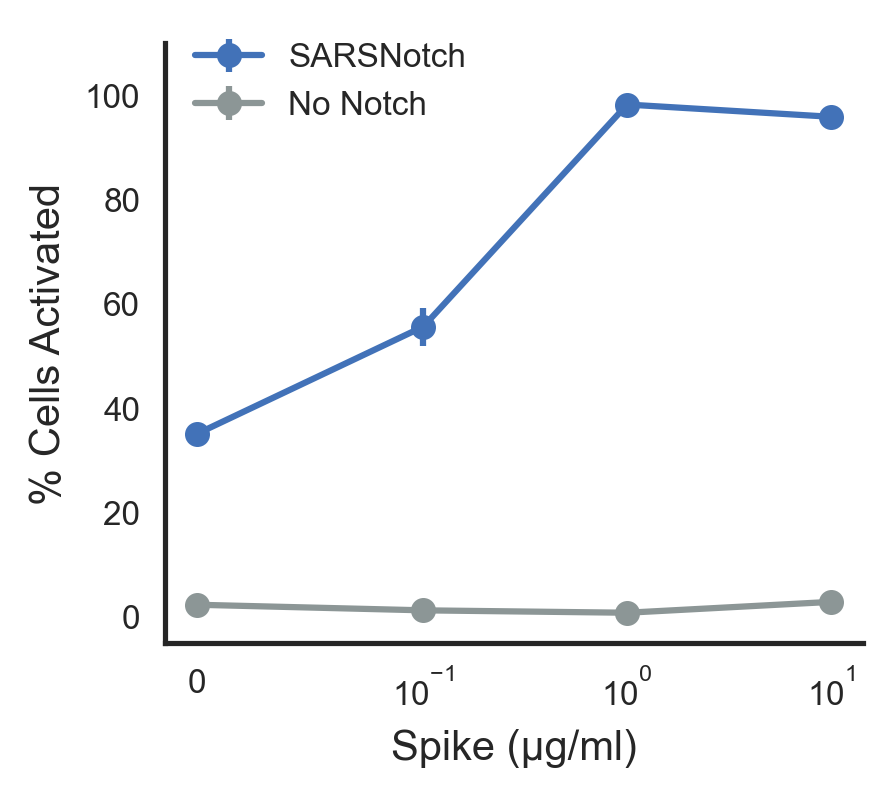

In [7]:
fig, ax = plt.subplots(1,1,figsize=(3,2.65), dpi=300)
for notch, color in zip(['No Notch', 'SARSNotch'],['#8C9696','#4272B8']):
    notch_summary = summary[(summary['Receiver']==notch)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('symlog', linthreshx=0.1)
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
order = [1, 0]
handles, labels = ax.get_legend_handles_labels()
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([-5,110])
sns.despine()
plt.savefig(outputdir+'bhk_spike_dr.svg')

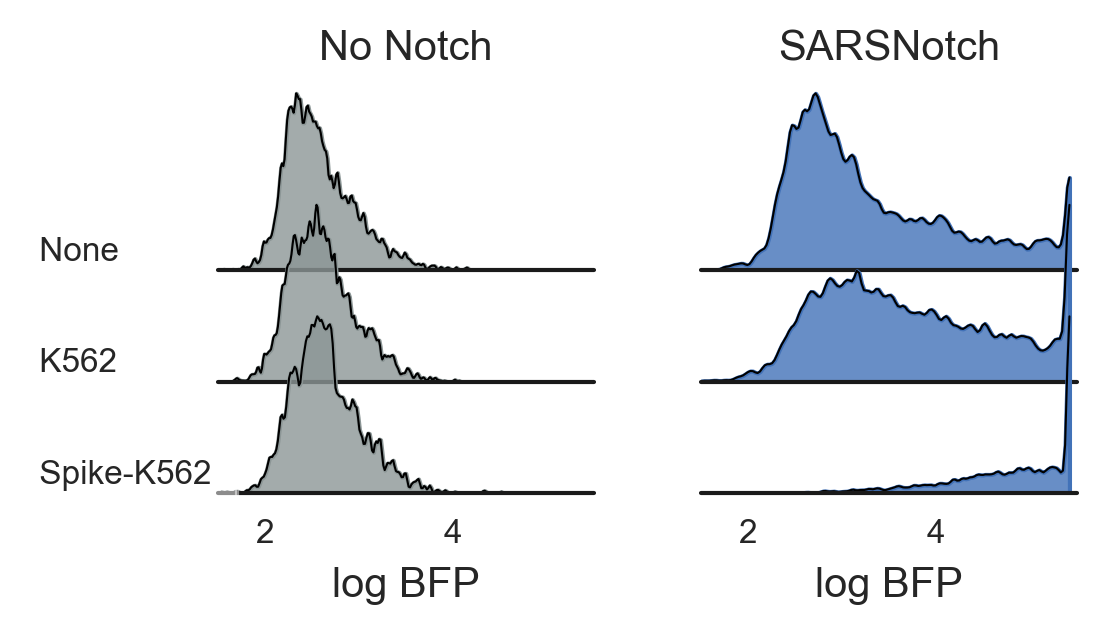

In [8]:
with sns.color_palette(["#8C9696", "#4272B8"]):
    notches = ['No Notch', 'SARSNotch']
    senders = ['None', 'K562', 'Spike-K562']
    g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                               (df2['Dose'].isin(['0','None'])) &
                               (df2['logFITC-A'] > 5)],
                      row='Sender', col='Receiver', hue='Receiver',sharey=False, aspect=2.5, height=0.65, 
                      row_order = senders,
                      hue_order = notches,
                      col_order = notches,
                      xlim=[1.5, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)
    [ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]
    left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
    for ax in left_axes:
        dose = ax.get_title().split("=")[1].split('|')[0]
        ax.text(-0.5,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
    for ax, notch in zip(top_axes, notches):
        ax.set_title(notch)

    # Remove axes details that don't play well with overlap
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.fig.set_dpi(300)
    g.set_xlabels("log BFP")
    plt.savefig(outputdir+'bhk_k562_histogram.svg')

In [9]:
filters = ((df2['logFITC-A'] > 4) &
           (df2['Dose'].isin(['None', '0'])))
dist = df2[filters]['logBV 421-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
summary = (df2[filters].groupby(['Receiver', 'Sender', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

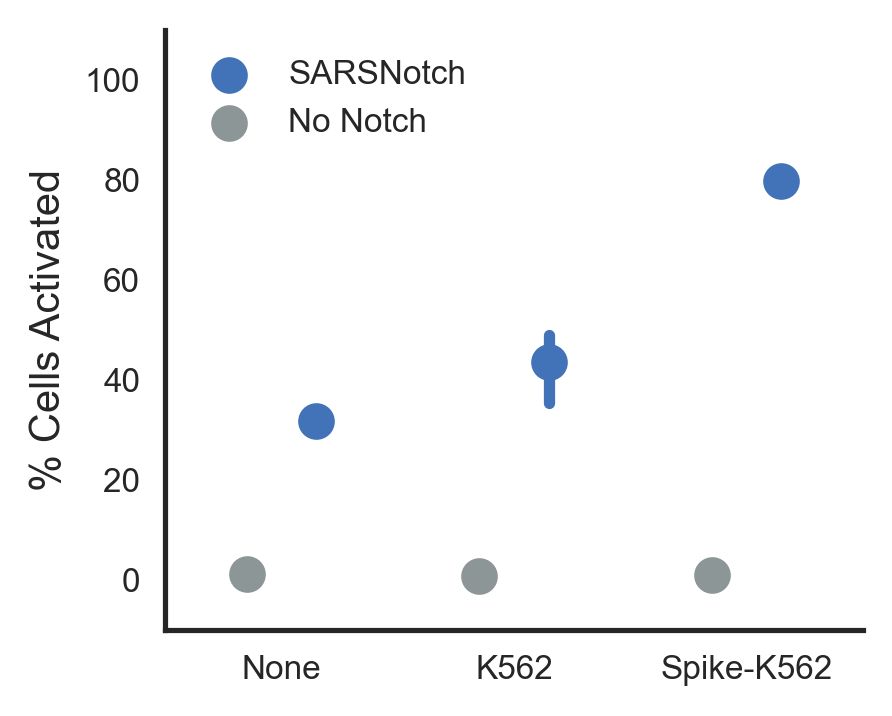

In [10]:
with sns.color_palette(['#8C9696','#4272B8', ]):
    fig, ax = plt.subplots(1,1, figsize=(3, 2.65),dpi=300)
    g = sns.pointplot(data=summary, x='Sender', y='logBV 421-A', order=['None', 'K562', 'Spike-K562'],
                      hue='Receiver', hue_order=['No Notch', 'SARSNotch'], 
                      dodge=0.3, join=False, ax=ax, markersize=10)
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left')
    g.set_xlabel('')
    g.set_ylabel('% Cells Activated')
    plt.ylim([-10,110])
    sns.despine()
    plt.savefig(outputdir + 'bhk_cell_response.svg')

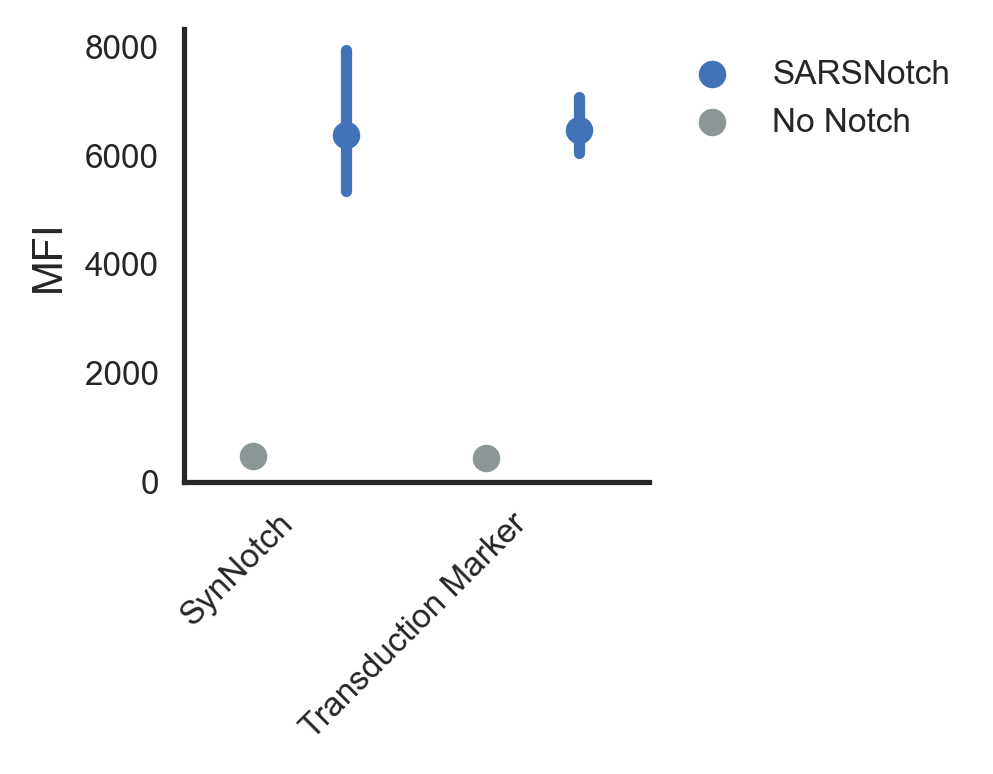

In [11]:
simplified_df = (df2[df2['logFITC-A'] > 5]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','Receiver','Sender','Dose','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['Receiver','Sender','Dose','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'SynNotch'

with sns.color_palette(['#8C9696','#4272B8']):
    fig, ax = plt.subplots(1,1,figsize=(2,2),dpi=300)
    g = sns.pointplot(data=simplified_df[(simplified_df['Dose']=='0') &
                                         (simplified_df['Receiver'].isin(['No Notch','SARSNotch'])) &
                                         (simplified_df['Sender'] == 'None')], 
                      x='channel', y='counts', hue='Receiver', join=False, dodge=0.4,
                      hue_order=['No Notch', 'SARSNotch'], scale=0.75)
    g.legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order],
               [labels[idx] for idx in order],
               frameon=False, loc='upper left', bbox_to_anchor=[1,1])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel('MFI')
    sns.despine()
    plt.savefig(outputdir + 'mfi_bhks.svg')